# Optimizing SR on Ideal Topography, Multiple Ensembles

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import time
import scipy.optimize

import params_ideal as params

from fun_ideal import calc_flood_height, generate_groups, calc_group_vol, calc_group_h, get_wall_heights
from ideal_damage import Damage
from topo_ideal import Topo

damage_table_file = r'Input/damage_table_combined.csv'
topo_file = "Input/ideal_topo_gp_points_1.csv"
div_data_file = "Input/ideal_div_data.csv"

ensemble_count = 10 # Number of ensembles

damage_table = pd.read_csv(damage_table_file) # Piecewise linear approx to damage on manhattan (all divs)
Topo = Topo(topo_file=topo_file)
Damage = Damage(damage_table_file)

segment_l = 100
wall_height = np.zeros(Topo.shore_height.size)


In [2]:
params.travel_dist = 999 # Make sure redistribution is inf
groups = generate_groups(Topo.div_data) # Groups for redistribution (full domain with travel dist inf)

h_max = 5 # Solution space boundary
dh = 0.05 # Resolution

# Grid search

In [3]:
min_height = np.min(Topo.shore_height)
N = int(np.max(np.ceil((h_max - min_height)/dh), 0))

damage_div = np.empty((N, ensemble_count, 18)) # Uggly hardcode 18 divs

surge_lst = [None]*ensemble_count
surge_time_lst = [None]*ensemble_count


time_start = time.time()
for ens in range(ensemble_count):
    surge_w = r'../SurgeData/%d-waterlevel_w.csv'%ens
    surge_c = r'../SurgeData/%d-waterlevel_c.csv'%ens
    time_w = r'../SurgeData/%d-time_w.csv'%ens
    time_c = r'../SurgeData/%d-time_w.csv'%ens
    
    surge_lst[ens] = np.concatenate((pd.read_csv(surge_w).to_numpy(), pd.read_csv(surge_c).to_numpy()), axis=0)
    surge_time_lst[ens] = np.concatenate((pd.read_csv(time_w).to_numpy(), pd.read_csv(time_c).to_numpy()), axis=0)
      
damage_per_ens = np.zeros(ensemble_count)
points = np.zeros((N, 2))
for n in range(N):
    
    height = min_height + n*dh
    points[n,0] = height
    
    pos, wall_heights = get_wall_heights(Topo, height)
    cost_wall = np.sum(49212 * wall_heights * segment_l)
    
    for ens in range(ensemble_count):
        surge = surge_lst[ens]
        surge_time = surge_time_lst[ens]
        
        height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_heights, pos)
        # calculate group volumes
        volume_grouped = calc_group_vol(groups, volume_div)
        
        # get height in each group
        surge_peak = np.amax(surge, axis=1)
        height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)
        
        #Damage
        dmg = Damage.calc_damage(height_grouped)
        #dmg_per_storm = np.sum(dmg, axis=1)
        dmg_per_div = np.sum(dmg, axis=0)
        damage_per_ens[ens] = np.sum(dmg_per_div)
        #damage_div[n, ens, :] = dmg_per_div
    
    dmg_avg = np.sum(damage_per_ens) / ensemble_count
    cost_tot = dmg_avg + cost_wall
    
    points[n,1] = cost_tot

print(time.time() - time_start)

36.70300006866455


Text(0.5, 0, 'Shore height (m)')

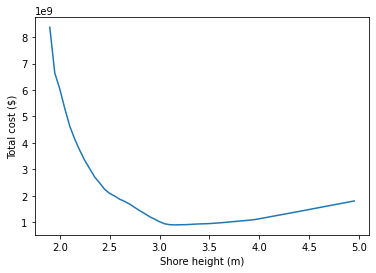

In [5]:
df = pd.DataFrame(points)
df.to_csv("sr_ideal_opt_grid_search_all_ens.csv")
plt.figure()
plt.plot(points[:,0], points[:,1])
plt.ylabel(r"Total cost ($)")
plt.xlabel(r"Shore height (m)")

In [15]:
opt_idx = np.argmin(points[:,1])
opt_x = points[opt_idx, 0]
opt_obj = points[opt_idx, 1]
print(opt_x)
print(opt_obj)

3.15
903575505.2877972


# Define Objective Func

In [6]:
def objective(height, surge_lst, surge_time_lst):

    pos, wall_heights = get_wall_heights(Topo, height)
    cost_wall = np.sum(49212 * wall_heights * segment_l)

    for ens in range(ensemble_count):
        surge = surge_lst[ens]
        surge_time = surge_time_lst[ens]

        height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_heights, pos)

        # calculate group volumes
        volume_grouped = calc_group_vol(groups, volume_div)

        # get height in each group
        surge_peak = np.amax(surge, axis=1)
        height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)

        #Damage
        dmg = Damage.calc_damage(height_grouped)
        dmg_per_storm = np.sum(dmg, axis=1)
        dmg_per_div = np.sum(dmg, axis=0)
        damage_per_ens[ens] = np.sum(dmg_per_div)

    dmg_avg = np.sum(damage_per_ens) / ensemble_count
    cost_tot = dmg_avg + cost_wall

    return cost_tot

# Optimize with scipy minimize


In [7]:
surge_lst = [None]*ensemble_count
surge_time_lst = [None]*ensemble_count
for ens in range(ensemble_count):
    surge_w = r'../SurgeData/%d-waterlevel_w.csv'%ens
    surge_c = r'../SurgeData/%d-waterlevel_c.csv'%ens
    time_w = r'../SurgeData/%d-time_w.csv'%ens
    time_c = r'../SurgeData/%d-time_w.csv'%ens

    surge_lst[ens] = np.concatenate((pd.read_csv(surge_w).to_numpy(), pd.read_csv(surge_c).to_numpy()), axis=0)
    surge_time_lst[ens] = np.concatenate((pd.read_csv(time_w).to_numpy(), pd.read_csv(time_c).to_numpy()), axis=0)

    damage_per_ens = np.zeros(ensemble_count)

x_opt = scipy.optimize.minimize(objective, 2, args=(surge_lst, surge_time_lst), method='Nelder-Mead', tol = 1.0e6, options = {'disp': True, 'return_all': True})
print(x_opt)

Optimization terminated successfully.
         Current function value: 903541141.315787
         Iterations: 9
         Function evaluations: 18
       allvecs: [array([2.]), array([2.3]), array([2.7]), array([3.1]), array([3.1]), array([3.2]), array([3.15]), array([3.15]), array([3.1375])]
 final_simplex: (array([[3.1375],
       [3.15  ]]), array([9.03541141e+08, 9.03575505e+08]))
           fun: 903541141.3157867
       message: 'Optimization terminated successfully.'
          nfev: 18
           nit: 9
        status: 0
       success: True
             x: array([3.1375])
